# Step 1: import the package 

In [1]:
import anasyspythontools as apt

In [2]:
# ignore these settings, they are just needed to make this render well on github

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Step 2: load data

In [3]:
anafile = apt.read("calibration.axz")

# Step 3-$\infty$: do stuff

## Example 1: What's in the file?

If you are working in Jupyter Notebook or Lab you can quickly check the contents of your file. To see all Images type (on the last line of a cell)

DataChannel,deflection
DriftCorrectionX,0
DriftCorrectionY,-0
Label,Deflection 1
Position.X,-3123.17919921875
Position.Y,1985.3677978515625
Position.Z,0
Position,
Resolution.X,300
Resolution.Y,300
Resolution,

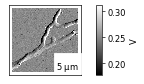
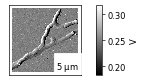
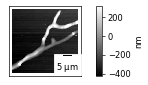
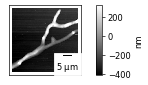
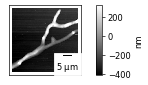

In [4]:
anafile.HeightMaps

To see all spectra, type (on the last line of a cell)

AmpZero,0
AttenuationBase64,[0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0.10438742 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ]
Background.AttenuatorPower,[Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') Decimal('1') D
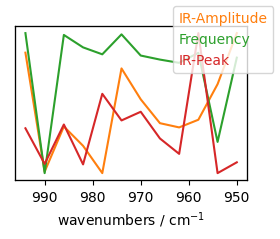
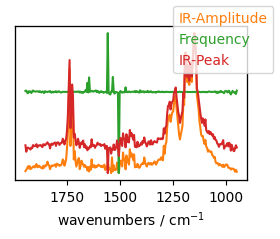

In [5]:
anafile2 = apt.read("PMMA spectra 1.axz")
anafile2.RenderedSpectra

## Example 2: Plotting images and spectra

There are four important attributes of our `anafile`

1. `HeightMaps`: All AFM image channels
2. `RenderedSpectra`: All spectra
3. `Images`: All camera images 
4. `Backgrounds`: All backgrounds referenced in the files

All of these are dictionaries, meaning you can check what is inside using `.keys()'  and get specific elements using indexing.

In [6]:
anafile.HeightMaps.keys()

dict_keys(['Deflection 1', 'Deflection 1 (1)', 'Height 1', 'Height 1 (1)', 'Height 1 (2)'])

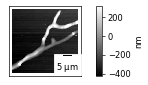

In [7]:
topo1 = anafile.HeightMaps["Height 1"]
topo1

Anasys python tools includes some helper functions for plotting AFM images:

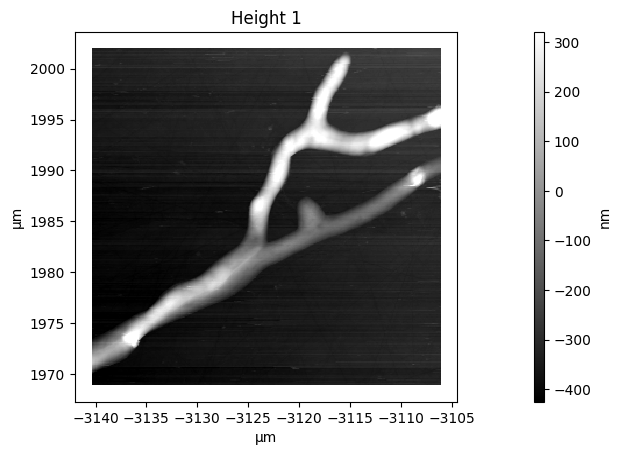

In [8]:
topo1.show(global_coords=True)

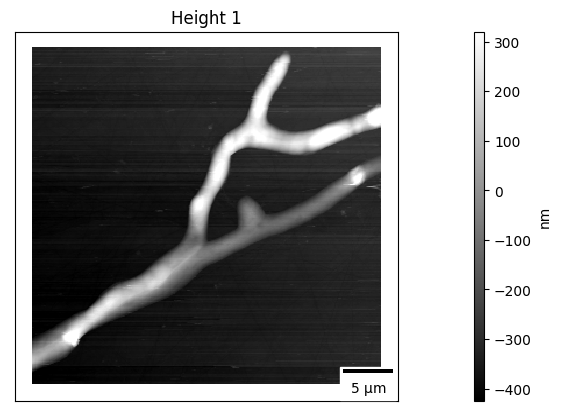

In [9]:
%matplotlib inline
topo1.show(global_coords=True, axes_style="microscopy")

Spectra can contain one or multiple data channels. They are stored in the `DataChannels` dictionary:

In [10]:
spec1 = anafile.RenderedSpectra["Spectrum 3"]

In [11]:
spec1.DataChannels.keys()

dict_keys(['Amp2 (V)'])

To plot spectra, use the `.wn` and `.signal` attribute of the data channel

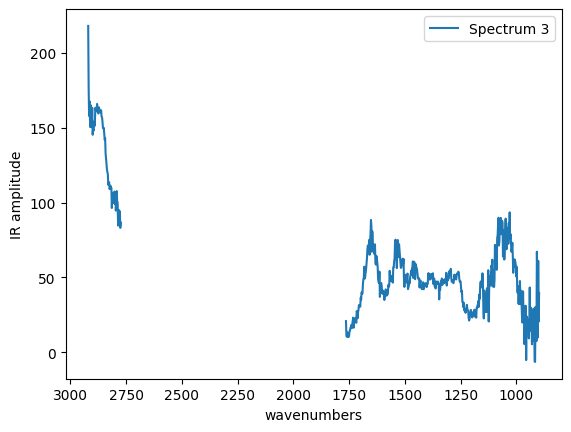

In [12]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(spec1.DataChannels["Amp2 (V)"].wn,spec1.DataChannels["Amp2 (V)"].signal, label=spec1.Label) 


#nicer formatting
def spectral_format(ax):
    ax.invert_xaxis()
    ax.set_xlabel("wavenumbers")
    ax.set_ylabel("IR amplitude")

spectral_format(ax)
ax.legend()


We can also use the information in spectra to plot their location on an image. 

**Important**: this only works if `global_coords=True` is passed.

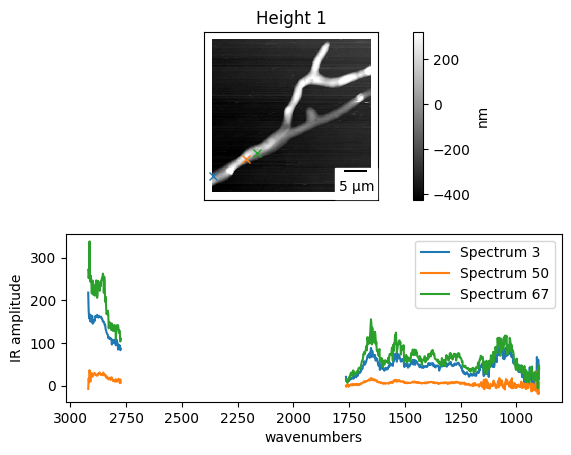

In [13]:
fig, ax = plt.subplots(2,1, squeeze=True)
topo1.show(global_coords=True, axes_style="microscopy", ax=ax[0])

for spectra_label in ["Spectrum 3", "Spectrum 50", "Spectrum 67"]:
    spec = anafile.RenderedSpectra[spectra_label]
    lines = ax[1].plot(spec.DataChannels["Amp2 (V)"].wn,
               spec.DataChannels["Amp2 (V)"].signal, 
               label=spec.Label) 
    ax[0].plot(spec.Location["X"], spec.Location["Y"], "x", 
              color = lines[0].get_color())
    

#nicer formatting
spectral_format(ax[1])
ax[1].legend()

## Example 3: Data processing using scipy and numpy

In [14]:
from scipy.signal import savgol_filter

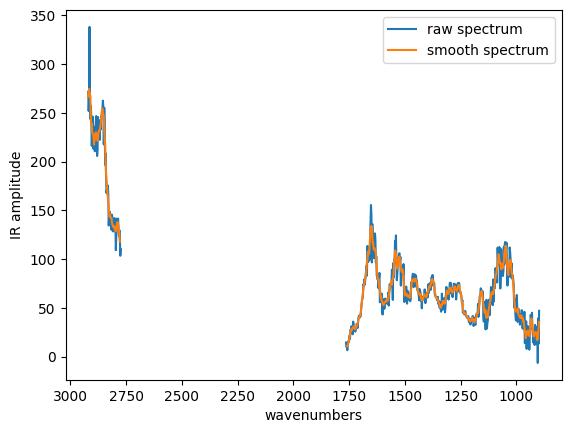

In [15]:
spec2 = anafile.RenderedSpectra["Spectrum 67"]
channel = spec2.DataChannels["Amp2 (V)"]
fig, ax = plt.subplots(1,1,squeeze=True)

ax.plot(channel.wn, channel.signal, label="raw spectrum")
ax.plot(channel.wn, savgol_filter(channel.signal, 5,1), label="smooth spectrum")



#nicer formatting
spectral_format(ax)
ax.legend()

# Example 4: export to xarray

The data structure of the `anasyspythontools`  package is closely tied to that of the AnalysisStudio package. Using it for more complex data analysis tasks get's quite cumbersome. Therefore, export functions for `xarray` types are provided.

In [16]:
from anasyspythontools.export import image_to_DataArray
import xarray as xr

Let's convert the topo image from before to an xarray. The numerical metadata are parsed to coordinates, that will come in handy later. The x and y coordinates of our image are exported as pixel indices `xpix`and `ypix`. We will add real world coordinates shortly. For now, note the  `transform` attribute.

In [17]:
arr_topo1 = image_to_DataArray(topo1)

arr_topo1

<xarray.DataArray (y: 300, x: 300)>
array([[-336.37237549, -336.57012939, -337.01507568, ..., -246.50952148,
        -246.0480957 , -244.59790039],
       [-331.29669189, -331.19781494, -333.55438232, ..., -243.65856934,
        -240.97219849, -239.70327759],
       [-330.8682251 , -337.77313232, -333.05999756, ..., -239.70327759,
        -240.67556763, -241.87857056],
       ...,
       [-420.96203613, -419.85791016, -417.51782227, ..., -330.63751221,
        -329.84649658, -330.83526611],
       [-413.67810059, -414.04064941, -413.74401855, ..., -305.73699951,
        -304.0725708 , -305.06134033],
       [-412.85412598, -411.28857422, -410.4810791 , ..., -307.4508667 ,
        -304.38568115, -301.65008545]])
Coordinates:
    xpix                   (x) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    ypix                   (y) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    Tags.ScanRate          float64 0.2
    Tags.Setpoint          float64 0.25
    Tags.IGain             float64 10.0
    Tags.PGain             float64 20.0
    Tags.ACDriveEnabled    bool True
    Tags.ACDriveFrequency  float64 nan
    Tags.ACDriveAmplitude  float64 nan
    TimeStamp              object 2020-02-06T15:33:22.592932+01:00
Dimensions without coordinates: y, x
Attributes:
    TimeStamp:          2020-02-06 15:33:22.592932+01:00
    transform:          [[ 1.14044940e-01  0.00000000e+00 -3.14028594e+03]\n ...
    Label:              Height 1 (PrimaryTrace)
    Tags.ScanMode:      Contact
    Tags.TraceRetrace:  PrimaryTrace

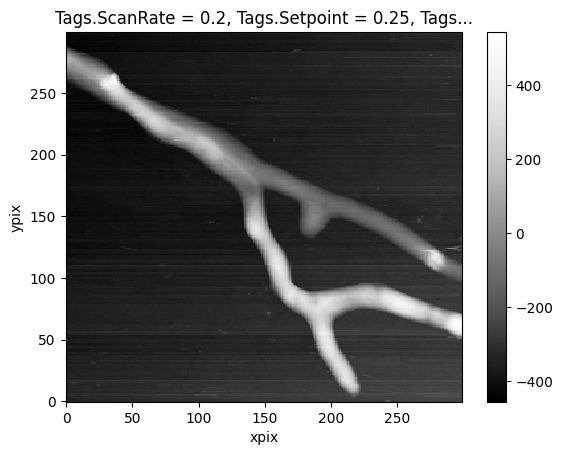

In [18]:
plt.figure()
arr_topo1.plot.pcolormesh(x="xpix", y="ypix", center=False, cmap="Greys_r")

## Transforming pixel coordinates

The `transform` attribute added during export is an affine transform (scale, rotate, shift) to transform pixel indices to micrometer pixel position the instrument was using. Using the `create_projected_coords` function new coordinates `X` and `Y` are added to the array that show these positions. 

**Note**: If there is rotation component in this affine transform, `X` and `Y` will be 2D, except if you forcibly ignore shear and rotation setting the `ignore_shear_rotate=False` key word argument.

In [19]:
from anasyspythontools.xarray_utils import create_projected_coords

In [20]:
arr_topo1 = create_projected_coords(arr_topo1)
arr_topo1

<xarray.DataArray (y: 300, x: 300)>
array([[-336.37237549, -336.57012939, -337.01507568, ..., -246.50952148,
        -246.0480957 , -244.59790039],
       [-331.29669189, -331.19781494, -333.55438232, ..., -243.65856934,
        -240.97219849, -239.70327759],
       [-330.8682251 , -337.77313232, -333.05999756, ..., -239.70327759,
        -240.67556763, -241.87857056],
       ...,
       [-420.96203613, -419.85791016, -417.51782227, ..., -330.63751221,
        -329.84649658, -330.83526611],
       [-413.67810059, -414.04064941, -413.74401855, ..., -305.73699951,
        -304.0725708 , -305.06134033],
       [-412.85412598, -411.28857422, -410.4810791 , ..., -307.4508667 ,
        -304.38568115, -301.65008545]])
Coordinates:
    xpix                   (x) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    ypix                   (y) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    Tags.ScanRate          float64 0.2
    Tags.Setpoint          float64 0.25
    Tags.IGain             float64 10.0
    Tags.PGain             float64 20.0
    Tags.ACDriveEnabled    bool True
    Tags.ACDriveFrequency  float64 nan
    Tags.ACDriveAmplitude  float64 nan
    TimeStamp              object 2020-02-06T15:33:22.592932+01:00
    X                      (x) float64 -3.14e+03 -3.14e+03 ... -3.106e+03
    Y                      (y) float64 2.002e+03 2.002e+03 ... 1.969e+03
Dimensions without coordinates: y, x
Attributes:
    TimeStamp:          2020-02-06 15:33:22.592932+01:00
    transform:          [[ 1.14044940e-01  0.00000000e+00 -3.14028594e+03]\n ...
    Label:              Height 1 (PrimaryTrace)
    Tags.ScanMode:      Contact
    Tags.TraceRetrace:  PrimaryTrace

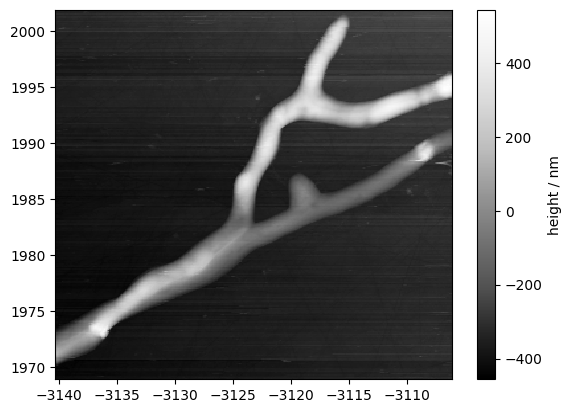

In [44]:
plt.figure()
arr_topo1.plot.pcolormesh(x="X", y="Y", center=False, 
                          cmap="Greys_r", add_labels=False, 
                          cbar_kwargs={"label":"height / nm"})

Using `xarray`, we can very easily do math with our data without getting confused about dimensions. E.g. if we want to do a baseline correction by subtracting the minimum value from each row, it looks as follows:

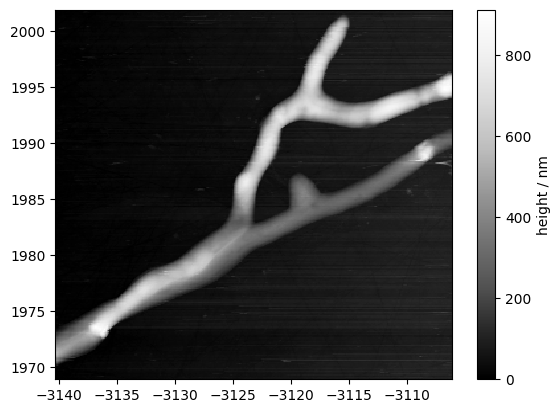

In [41]:
baseline_corrected = arr_topo1 - arr_topo1.min(dim="x")

plt.figure()
baseline_corrected.plot.pcolormesh(x="X", y="Y", center=False, cmap="Greys_r", 
                                   add_labels=False,
                                  cbar_kwargs={"label":"height / nm"})

We can select pixels using coordinates 

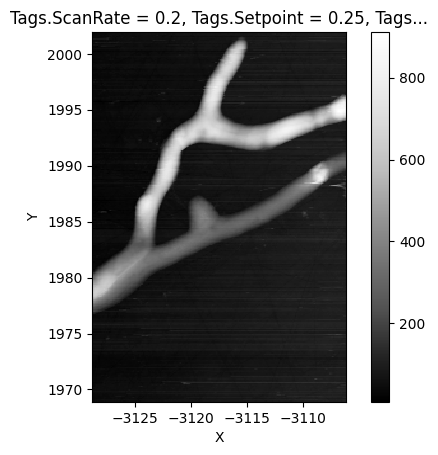

In [23]:
plt.figure()
baseline_corrected.sel(x=baseline_corrected.xpix>100).plot.pcolormesh(x="X", y="Y", 
                                                                      center=False, 
                                                                      cmap="Greys_r")
plt.gca().set_aspect(1)

or by value:

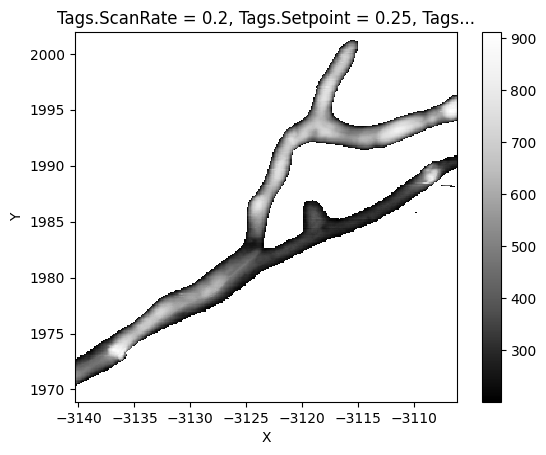

In [24]:
plt.figure()
baseline_corrected.where(baseline_corrected>200).plot.pcolormesh(x="X", y="Y", center=False,  cmap="Greys_r")
plt.gca().set_aspect(1)

And, finally, here is a more complex example selecting all pixels below a cutoff value, fitting them with a line and using that line for baseline correction:

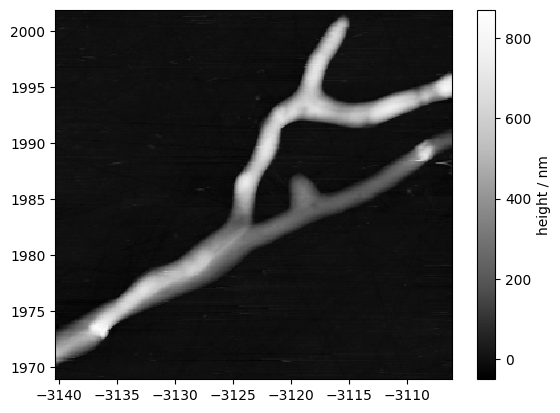

In [43]:
plt.figure()

(baseline_corrected - xr.polyval(baseline_corrected.xpix, 
                                 baseline_corrected.where(baseline_corrected<200)\
                                  .polyfit(dim="x", deg=1).polyfit_coefficients))\
                                    .plot.pcolormesh(x="X", y="Y", center=False,
                                                     cmap="Greys_r",
                                                    add_labels=False, 
                                                    cbar_kwargs={"label":"height / nm"})


Analysis Studio doesn't really tell us that specific images "belong together". But it stores the time at which an image was recorded. The helper function `get_concurrent_images` allows us to find all images that were stored at the same time (and, e.g., had the same scan direction):

In [26]:
from anasyspythontools.export import get_concurrent_images, imagelist_to_Dataset

In [27]:
concur_images = get_concurrent_images(anafile.HeightMaps.values())

concur_images

{map_properties(TimeStamp='2020-02-06T15:33:22.5929323+01:00', TraceRetrace='PrimaryTrace'): [<anasyspythontools.heightmap.HeightMap at 0x7f2fe8f8a490>,
 map_properties(TimeStamp='2020-02-06T15:33:22.5929323+01:00', TraceRetrace='PrimaryRetrace'): [<anasyspythontools.heightmap.HeightMap at 0x7f2fb00b30a0>,
  <anasyspythontools.heightmap.HeightMap at 0x7f2fb00b3190>]}

There are two sets of images in our file: One for trace and one for retrace

In [28]:
imgs = [imagelist_to_Dataset(img) for img in concur_images.values()]
img0 = create_projected_coords(imgs[0])

Multiple images are combined into `Dataset`s. Each channel is stored as a variable. We can retrie it using either `.` atrribute notation or `[]` subscript notation. We can also get coordinates, such as the set point the same way. 

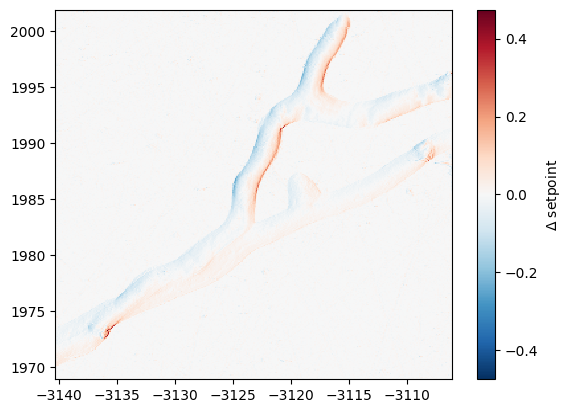

In [29]:
plt.figure()
(img0.deflection-img0["Tags.Setpoint"])\
    .plot.pcolormesh(x="X", y="Y", add_labels=False,
                     cbar_kwargs={"label":"$\Delta$ setpoint"})


We can also use the information in one channel to do calculations on another channel. For example the feedback channels (deflection and amplitude) can tell us how well we were tracking the sample. Since the AFM-IR signal is affected by tip-sample contact it makes sense to exclude pixels from evaluation that appear to result from bad contact.

In the following code we only use height images pixels where the deflection was less than .05 V from the set point.

Text(0.5, 1.0, '')

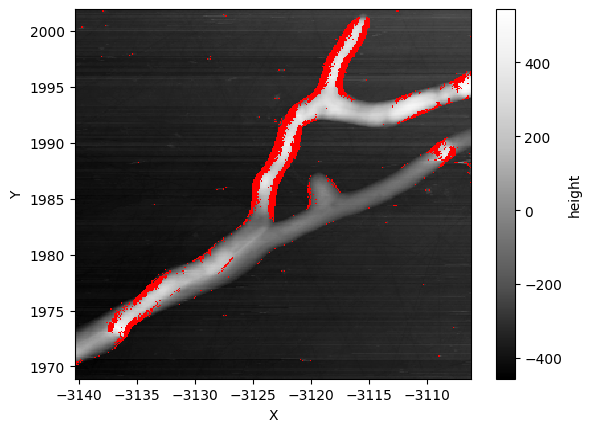

In [30]:
import numpy as np

plt.figure()
img0.height.where(np.abs(img0.deflection-img0["Tags.Setpoint"])<.05) \
            .plot.pcolormesh(x="X", y="Y", 
                   center=False,
                    cmap="Greys_r")
ax = plt.gca()
ax.set_facecolor("red")
plt.title("")

## Exporting Spectra

Since spectra can contain multiple data channels, they are by default exported as dataset.

In [31]:
from anasyspythontools.export import spectrum_to_Dataset, spectra_list_to_Dataset

In [32]:
spec_arr = spectrum_to_Dataset(anafile.RenderedSpectra["Spectrum 64"])
spec_arr

<xarray.Dataset>
Dimensions:      (wavenumbers: 1012)
Coordinates:
  * wavenumbers  (wavenumbers) float64 898.0 900.0 902.0 ... 2.918e+03 2.92e+03
    Location.X   float64 -3.131e+03
    Location.Y   float64 1.978e+03
    PulseRate    float64 211.4
    TimeStamp    object 2020-02-06T16:42:07.294932+01:00
Data variables:
    Amp2 (V)     (wavenumbers) float64 25.64 14.83 24.98 ... 266.1 282.9 277.5
    Background   (wavenumbers) float64 0.00161 0.001807 ... 0.001726 0.001521
Attributes:
    Label:    Spectrum 64

Here is basic plot of the spectrum and the background.

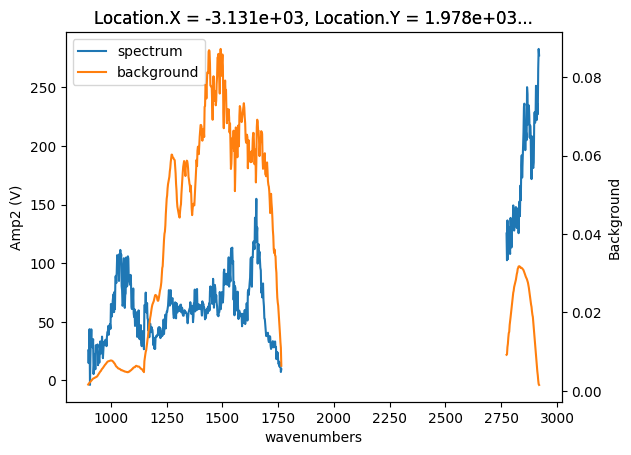

In [33]:
fig, ax = plt.subplots()

lin = spec_arr["Amp2 (V)"].plot.line(x="wavenumbers", ax=ax, color="C0", label="spectrum")
lin+=spec_arr["Background"].plot.line(x="wavenumbers", ax=ax.twinx(), color="C1", label="background")
ax.legend(handles=lin)

I want to close this with a really short example, that combines data evalution and visualization in a few quick lines of code:

In [34]:
all_spectra = spectra_list_to_Dataset(anafile.RenderedSpectra.values())
all_spectra

<xarray.Dataset>
Dimensions:      (wavenumbers: 1012, spectral_index: 379)
Coordinates:
  * wavenumbers  (wavenumbers) float64 898.0 900.0 902.0 ... 2.918e+03 2.92e+03
    Location.X   (spectral_index) float64 -3.14e+03 -3.14e+03 ... -3.119e+03
    Location.Y   (spectral_index) float64 1.972e+03 1.972e+03 ... 1.985e+03
    PulseRate    (spectral_index) float64 210.0 210.0 217.1 ... 207.1 207.1
    TimeStamp    (spectral_index) object 2020-02-06T16:02:12.145932+01:00 ......
Dimensions without coordinates: spectral_index
Data variables:
    Amp2 (V)     (spectral_index, wavenumbers) float64 17.35 6.872 ... 14.83
    Background   (spectral_index, wavenumbers) float64 0.00161 ... 0.001521
Attributes:
    Label:    Spectrum 1

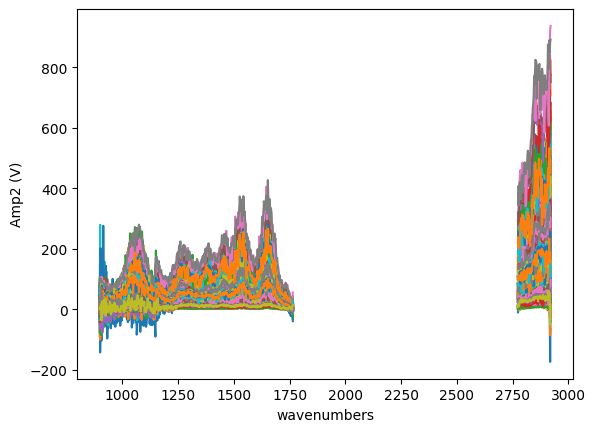

In [35]:
plt.figure()
all_spectra["Amp2 (V)"].plot.line(x="wavenumbers", add_legend=False);

When we use resonance enhanced AFM-IR for spectroscopy the laser needs to be chirped before each spectrum to figure out the contact resonance. The laser repetition rate is only allowed to be within a certain range. If it is outside that range, we have a good indication that something went wrong. Since we have access to metadata we can look at the distribution directly-

Text(0, 0.5, 'counts')

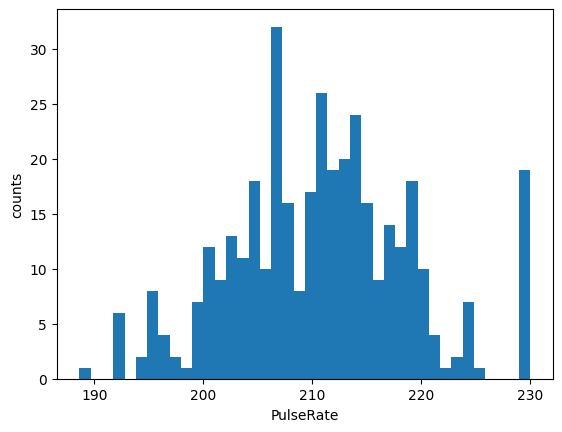

In [36]:
plt.figure()

all_spectra.PulseRate.plot.hist(bins=40)

plt.ylabel("counts")

We use the integral of the amide II to kick out all spectra that have too much noise. Let's see where we need to place the cut off in a histogram of all integrals:

(array([15.,  4.,  2., 10.,  6.,  9.,  6.,  9.,  8., 15., 18., 13., 11.,
        14., 10.,  6., 10.,  8.,  9., 10.,  5., 10., 11.,  7.,  6.,  5.,
         8.,  7.,  6.,  8.,  7.,  7.,  6.,  4.,  4.,  2.,  5.,  0.,  5.,
         3.,  5.,  1.,  4.,  3.,  5.,  1.,  4.,  3.,  0.,  3.,  5.,  1.,
         1.,  0.,  2.,  1.,  1.,  3.,  0.,  1.,  3.,  2.,  0.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  311.44069552,   559.37553936,   807.3103832 ,  1055.24522704,
         1303.18007088,  1551.11491472,  1799.04975855,  2046.98460239,
         2294.91944623,  2542.85429007,  2790.78913391,  3038.72397774,
         3286.65882158,  3534.59366542,  3782.52850926,  4030.4633531 ,
         4278.39819694,  4526.33304077,  4774.26788461,  5022.20272845,
         5270.13757229,  5518.07241613,  5766.00725996,  6013.9421038 ,
  

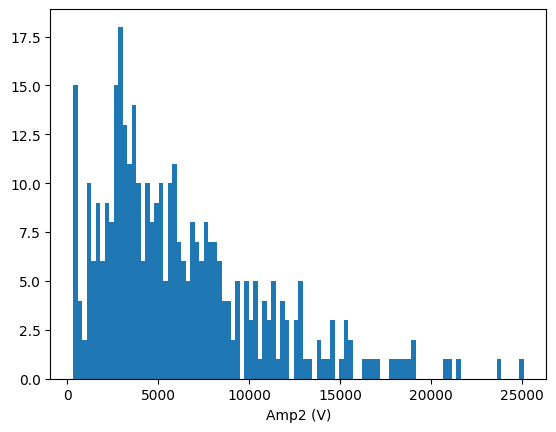

In [37]:
plt.figure()
integrals = all_spectra["Amp2 (V)"].sel(wavenumbers=slice(1500,1600)).integrate(coord="wavenumbers")
integrals.plot.hist(bins=100)

1100 looks like a reasonable number.

In [38]:
subset = all_spectra.sel(spectral_index=integrals>=1100)

And we can e.g. plot the integral of the amide I onto our image:

Text(0.5, 1.0, '')

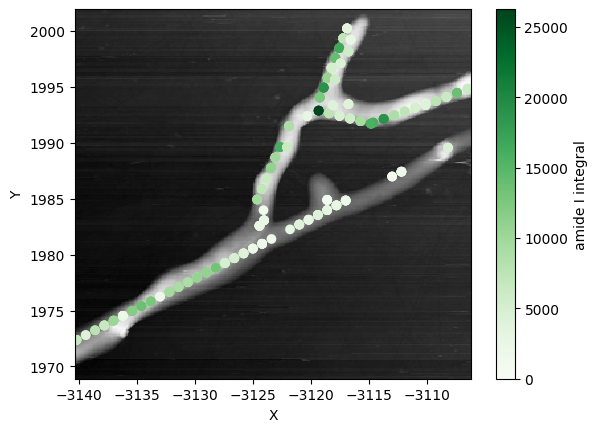

In [39]:
fig, ax = plt.subplots()

img0.height.plot(x="X", y="Y", center=False, cmap="Greys_r", ax=ax, add_colorbar=False)


ints_amideI = subset["Amp2 (V)"].sel(wavenumbers=slice(1600,1700)).integrate(coord="wavenumbers")

scatter = ax.scatter(ints_amideI["Location.X"], ints_amideI["Location.Y"], c=ints_amideI, cmap="Greens",vmin=0)

fig.colorbar(scatter, ax=ax, label="amide I integral")

ax.set_title("")

In [40]:
ax.scatter(ints_amideI["Location.X"], ints_aideI["Location.Y"], c=ints_amideI)

NameError: name 'ints_aideI' is not defined